In [1]:
import pickle

In [2]:
with open('cond_dists.pkl', 'rb') as inp:
    cond_dists = pickle.load(inp)


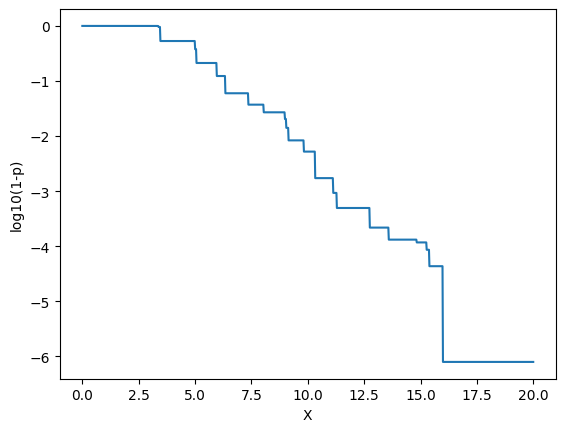

In [9]:
cond_dists[199].plot_distribution()